In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, date, timedelta

# Prep.

## Data

In [2]:
dt = pd.read_csv('./data/clean_data.csv')
dt.order_approved_at = dt.order_approved_at.apply(lambda x : datetime.strptime(x, "%Y-%m-%d").date())
dt = dt[~dt.review_score.isna()]

## Functions

In [95]:
# Function to return a given period on the df

def period_selection_v2(dt, end, n_days):
    to_return = dt.copy()
    start = min(dt.order_approved_at)
    end = end + timedelta(days = n_days)
    print("Start : {}, end : {}".format(start, end))

    to_return = to_return[ (to_return.order_approved_at < end) ].copy()         
    return to_return 

# Define function to compute RFM + mean review score (rfm extended)
def rfm_ex(dt):
    
    min_date = min(dt.order_approved_at)
    max_date = max(dt.order_approved_at)
    period_length_days = (max_date - min_date).days
    
    # Get last order for each customer unique id
    recence = dt.loc[:,['customer_unique_id', 'order_approved_at'] ].\
                sort_values(by="order_approved_at").\
                drop_duplicates(subset=["customer_unique_id"], keep="last").\
                reset_index(drop=True)
    
    # Compute time since last order
    recence.loc[:,'order_approved_at'] = recence.loc[:,'order_approved_at'].apply(lambda x : (max_date - x).days )

    recence.rename(columns={"order_approved_at": "recence",}, inplace=True)
    
    # Get frequency
    frequence = dt.groupby('customer_unique_id').customer_unique_id.count() / period_length_days
    frequence = pd.DataFrame({ 'customer_unique_id' : frequence.index, 
                               'frequency' : frequence.values})
    
    # Montant (total ? mean ?)
    montant = dt.groupby('customer_unique_id').payment_value.sum() / period_length_days
    montant = pd.DataFrame({ 'customer_unique_id' : montant.index, 
                             'montant' : montant.values})
    
    # Review
    revs = dt.groupby('customer_unique_id').review_score.mean()
    revs = pd.DataFrame({ 'customer_unique_id' : revs.index, 
                          'review_score' : revs.values})
    
    rfm = recence.merge(frequence, on = 'customer_unique_id').\
                  merge(montant, on = 'customer_unique_id').\
                  merge(revs, on = 'customer_unique_id')
    return rfm

# Simulations 

In [96]:
from sklearn import cluster
from sklearn import metrics
from sklearn import preprocessing

def sim(dt, t0, periodicity, n_k, mod, n_step = 20, ax = None, return_conf = False):

    if mod == 'rfm':
        features = ['recence','frequency','montant']
    else:
        features = ['recence','frequency','montant','review_score']
        
    last_date = max(dt.order_approved_at)
    n_step_stop = 0 
    for i in range(n_step):
        if t0 + timedelta(days = i*periodicity) < last_date :
            n_step_stop = i
        
    if return_conf:
        confs = np.empty([n_step_stop, n_k, n_k], dtype=int)
                    
    init = rfm_ex(period_selection_v2(dt, end = t0, n_days = 0)).loc[:,features]
    ss_init = preprocessing.StandardScaler().fit(init)

    mod_init = cluster.KMeans(init="k-means++", n_clusters = n_k).fit(ss_init.transform(init))
    
    acc_thresh = 0.9
    ari_thresh = 0.8
    
    aris = []
    acc = []

    for i in range(0, n_step_stop):
        n_dt = rfm_ex(period_selection_v2(dt, end = t0, n_days = i*periodicity)).loc[:,features]
        clust_init = mod_init.predict(ss_init.transform(n_dt))
        clust_loc = cluster.KMeans(init="k-means++", n_clusters = n_k).fit_predict(preprocessing.StandardScaler().fit_transform(n_dt))
        
        aris.append(metrics.adjusted_rand_score(clust_init, clust_loc))
        
        m = metrics.confusion_matrix(clust_init, clust_loc)
        c = np.apply_along_axis(lambda x : np.argmax(x), 0, m)
        acc.append(metrics.accuracy_score(clust_init, np.array(list(map(lambda x : c[x], clust_loc)))))
    
        if return_conf :
            m = m[c,:]
            ni_ = np.argsort(np.diagonal(m))
            confs[i,:,:] = m[ni_, :][:, ni_]

    acc_ = pd.DataFrame( { 'x' : np.array(range(0,n_step_stop))*periodicity,
                           'y' : acc,
                           'h' : 'acc' } )    
    
    ari_ = pd.DataFrame( { 'x' : np.array(range(0,n_step_stop))*periodicity,
                           'y' : aris,
                           'h' : 'ari' } )    
    
    tp = pd.concat([acc_, ari_])
    
    if ax is None:
        p=sns.scatterplot(y=tp['y'],x=tp['x'],hue=tp['h'])
    else:
        p=sns.scatterplot(y=tp['y'],x=tp['x'],hue=tp['h'], ax = ax)
    p.set(title = "Model : {}, k : {} - t0 : {}".format(mod, n_k, t0), 
          ylim=(0, 1.1), xlim=(-0.2, n_step*periodicity),
          ylabel = 'ARI/Accurancy')
    p.legend().set_title(None)
    p.axhline(ari_thresh, c = 'orange')
    p.axhline(acc_thresh, c = 'blue')
    p.axvline(np.argmax(np.array(aris)<ari_thresh)*periodicity, c = 'orange', linestyle = '--')
    p.axvline(np.argmax(np.array(acc)<acc_thresh)*periodicity, c = 'blue', linestyle = '--')
    plt.tight_layout()
    
    if return_conf:
        return confs
    

## RFM

### k = 3

Start : 2016-10-04, end : 2018-01-01
Start : 2016-10-04, end : 2018-01-01
Start : 2016-10-04, end : 2018-01-08
Start : 2016-10-04, end : 2018-01-15
Start : 2016-10-04, end : 2018-01-22
Start : 2016-10-04, end : 2018-01-29
Start : 2016-10-04, end : 2018-02-05
Start : 2016-10-04, end : 2018-02-12
Start : 2016-10-04, end : 2018-02-19
Start : 2016-10-04, end : 2018-02-26
Start : 2016-10-04, end : 2018-03-05
Start : 2016-10-04, end : 2018-03-12
Start : 2016-10-04, end : 2018-03-19
Start : 2016-10-04, end : 2018-03-26
Start : 2016-10-04, end : 2018-04-02
Start : 2016-10-04, end : 2018-04-09
Start : 2016-10-04, end : 2018-04-16
Start : 2016-10-04, end : 2018-04-23
Start : 2016-10-04, end : 2018-04-30
Start : 2016-10-04, end : 2018-05-07
Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-08
Start : 2016-10-04, end : 2018-03-15
Start : 2016-10-04, end : 2018-03-22
Start : 2016-10-04, end : 2018-03-29
Start : 2016-10-04, end : 2018-04-05
S

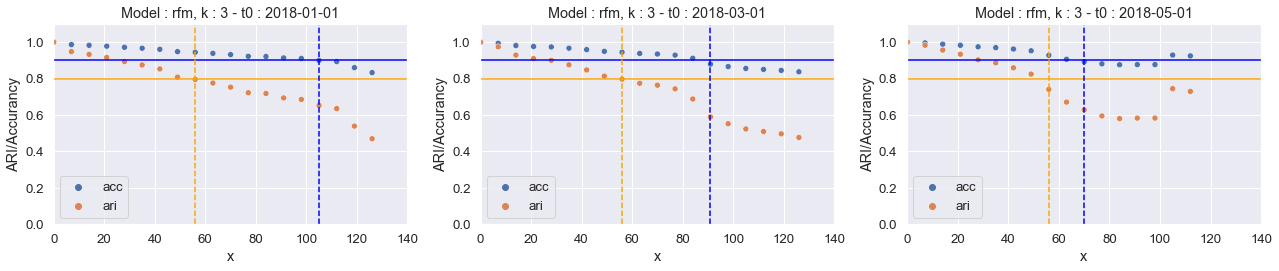

In [40]:
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(18,4)}, font_scale = 1.2)
fig, ax = plt.subplots(1,3)

n_steps = 20

sim(dt = dt, t0 = date(2018, 1, 1), periodicity = 7, n_k = 3, mod = 'rfm', n_step = n_steps, ax = ax[0]);
sim(dt = dt, t0 = date(2018, 3, 1), periodicity = 7, n_k = 3, mod = 'rfm', n_step = n_steps, ax = ax[1]);
sim(dt = dt, t0 = date(2018, 5, 1), periodicity = 7, n_k = 3, mod = 'rfm', n_step = n_steps, ax = ax[2]);

In [99]:
c=sim(dt = dt, t0 = date(2018, 3, 1), periodicity = 7, n_k = 3, mod = 'rfm', n_step = n_steps, ax = ax[1], return_conf=True);

Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-08
Start : 2016-10-04, end : 2018-03-15
Start : 2016-10-04, end : 2018-03-22
Start : 2016-10-04, end : 2018-03-29
Start : 2016-10-04, end : 2018-04-05
Start : 2016-10-04, end : 2018-04-12
Start : 2016-10-04, end : 2018-04-19
Start : 2016-10-04, end : 2018-04-26
Start : 2016-10-04, end : 2018-05-03
Start : 2016-10-04, end : 2018-05-10
Start : 2016-10-04, end : 2018-05-17
Start : 2016-10-04, end : 2018-05-24
Start : 2016-10-04, end : 2018-05-31
Start : 2016-10-04, end : 2018-06-07
Start : 2016-10-04, end : 2018-06-14
Start : 2016-10-04, end : 2018-06-21
Start : 2016-10-04, end : 2018-06-28
Start : 2016-10-04, end : 2018-07-05
Start : 2016-10-04, end : 2018-07-12
Start : 2016-10-04, end : 2018-07-19
Start : 2016-10-04, end : 2018-07-26
Start : 2016-10-04, end : 2018-08-02
Start : 2016-10-04, end : 2018-08-09
Start : 2016-10-04, end : 2018-08-16


<Figure size 1296x288 with 0 Axes>

## RFMe

### k = 4

Start : 2016-10-04, end : 2018-01-01
Start : 2016-10-04, end : 2018-01-01
Start : 2016-10-04, end : 2018-01-08
Start : 2016-10-04, end : 2018-01-15
Start : 2016-10-04, end : 2018-01-22
Start : 2016-10-04, end : 2018-01-29
Start : 2016-10-04, end : 2018-02-05
Start : 2016-10-04, end : 2018-02-12
Start : 2016-10-04, end : 2018-02-19
Start : 2016-10-04, end : 2018-02-26
Start : 2016-10-04, end : 2018-03-05
Start : 2016-10-04, end : 2018-03-12
Start : 2016-10-04, end : 2018-03-19
Start : 2016-10-04, end : 2018-03-26
Start : 2016-10-04, end : 2018-04-02
Start : 2016-10-04, end : 2018-04-09
Start : 2016-10-04, end : 2018-04-16
Start : 2016-10-04, end : 2018-04-23
Start : 2016-10-04, end : 2018-04-30
Start : 2016-10-04, end : 2018-05-07
Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-08
Start : 2016-10-04, end : 2018-03-15
Start : 2016-10-04, end : 2018-03-22
Start : 2016-10-04, end : 2018-03-29
Start : 2016-10-04, end : 2018-04-05
S

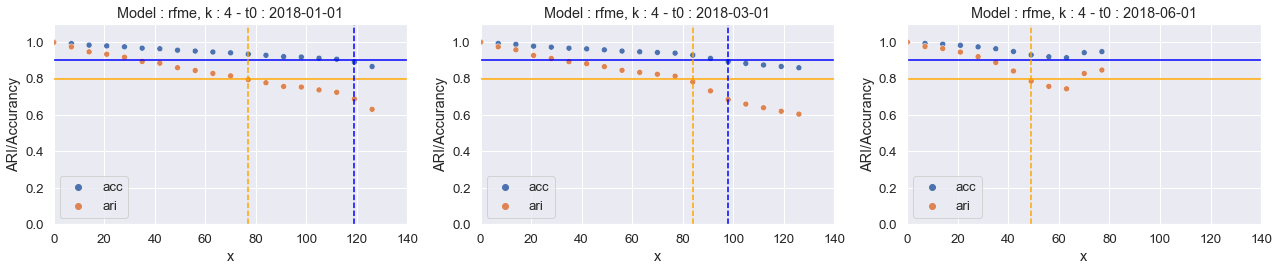

In [42]:
fig, ax = plt.subplots(1,3)

n_steps = 20

sim(dt=dt, t0 = date(2018, 1, 1), periodicity = 7, n_k = 4, mod = 'rfme', n_step = n_steps, ax = ax[0]);
sim(dt=dt,t0 = date(2018, 3, 1), periodicity = 7, n_k = 4, mod = 'rfme', n_step = n_steps, ax = ax[1]);
sim(dt=dt,t0 = date(2018, 6, 1), periodicity = 7, n_k = 4, mod = 'rfme', n_step = n_steps, ax = ax[2]);

### k = 5

Start : 2016-10-04, end : 2018-01-01
Start : 2016-10-04, end : 2018-01-01
Start : 2016-10-04, end : 2018-01-04
Start : 2016-10-04, end : 2018-01-07
Start : 2016-10-04, end : 2018-01-10
Start : 2016-10-04, end : 2018-01-13
Start : 2016-10-04, end : 2018-01-16
Start : 2016-10-04, end : 2018-01-19
Start : 2016-10-04, end : 2018-01-22
Start : 2016-10-04, end : 2018-01-25
Start : 2016-10-04, end : 2018-01-28
Start : 2016-10-04, end : 2018-01-31
Start : 2016-10-04, end : 2018-02-03
Start : 2016-10-04, end : 2018-02-06
Start : 2016-10-04, end : 2018-02-09
Start : 2016-10-04, end : 2018-02-12
Start : 2016-10-04, end : 2018-02-15
Start : 2016-10-04, end : 2018-02-18
Start : 2016-10-04, end : 2018-02-21
Start : 2016-10-04, end : 2018-02-24
Start : 2016-10-04, end : 2018-02-27
Start : 2016-10-04, end : 2018-03-02
Start : 2016-10-04, end : 2018-03-05
Start : 2016-10-04, end : 2018-03-08
Start : 2016-10-04, end : 2018-03-11
Start : 2016-10-04, end : 2018-03-14
Start : 2016-10-04, end : 2018-03-17
S

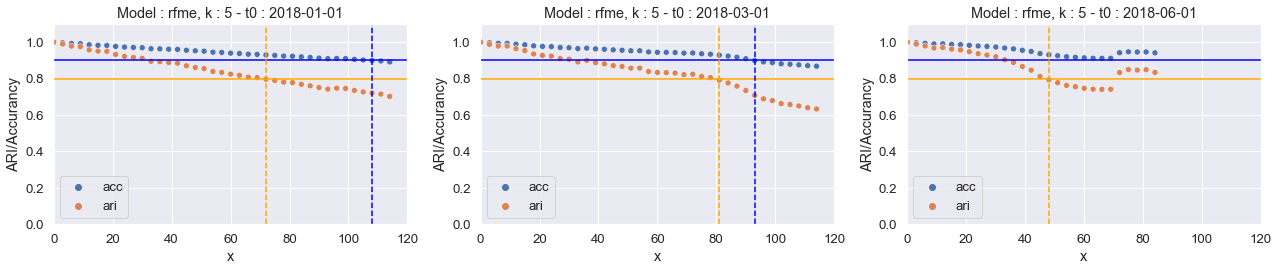

In [44]:
fig, ax = plt.subplots(1,3)

n_steps = 40

sim(dt = dt, t0 = date(2018, 1, 1), periodicity = 3, n_k = 5, mod = 'rfme', n_step = n_steps, ax = ax[0]);
sim(dt = dt, t0 = date(2018, 3, 1), periodicity = 3, n_k = 5, mod = 'rfme', n_step = n_steps, ax = ax[1]);
sim(dt = dt, t0 = date(2018, 6, 1), periodicity = 3, n_k = 5, mod = 'rfme', n_step = n_steps, ax = ax[2]);

Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-01
Start : 2016-10-04, end : 2018-03-08
Start : 2016-10-04, end : 2018-03-15
Start : 2016-10-04, end : 2018-03-22
Start : 2016-10-04, end : 2018-03-29
Start : 2016-10-04, end : 2018-04-05
Start : 2016-10-04, end : 2018-04-12
Start : 2016-10-04, end : 2018-04-19
Start : 2016-10-04, end : 2018-04-26
Start : 2016-10-04, end : 2018-05-03
Start : 2016-10-04, end : 2018-05-10
Start : 2016-10-04, end : 2018-05-17
Start : 2016-10-04, end : 2018-05-24
Start : 2016-10-04, end : 2018-05-31
Start : 2016-10-04, end : 2018-06-07
Start : 2016-10-04, end : 2018-06-14
Start : 2016-10-04, end : 2018-06-21
Start : 2016-10-04, end : 2018-06-28
Start : 2016-10-04, end : 2018-07-05


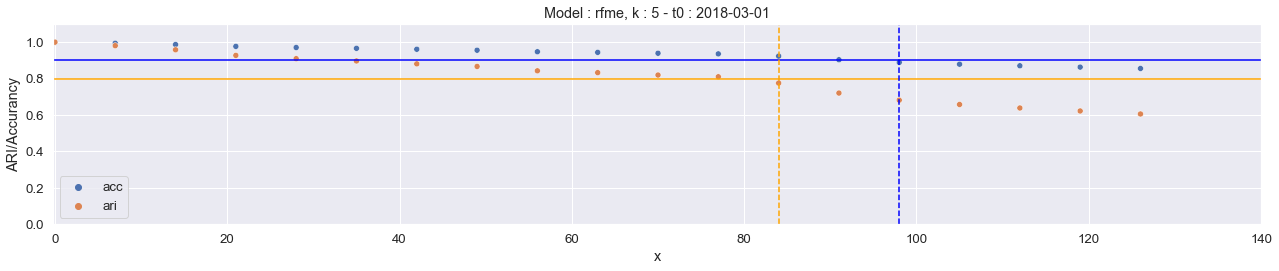

In [100]:
c=sim(dt = dt, t0 = date(2018, 3, 1), periodicity = 7, n_k = 5, mod = 'rfme', n_step = 20, return_conf=True);